In [1]:
%load_ext autoreload
%autoreload 2

### plotting setup

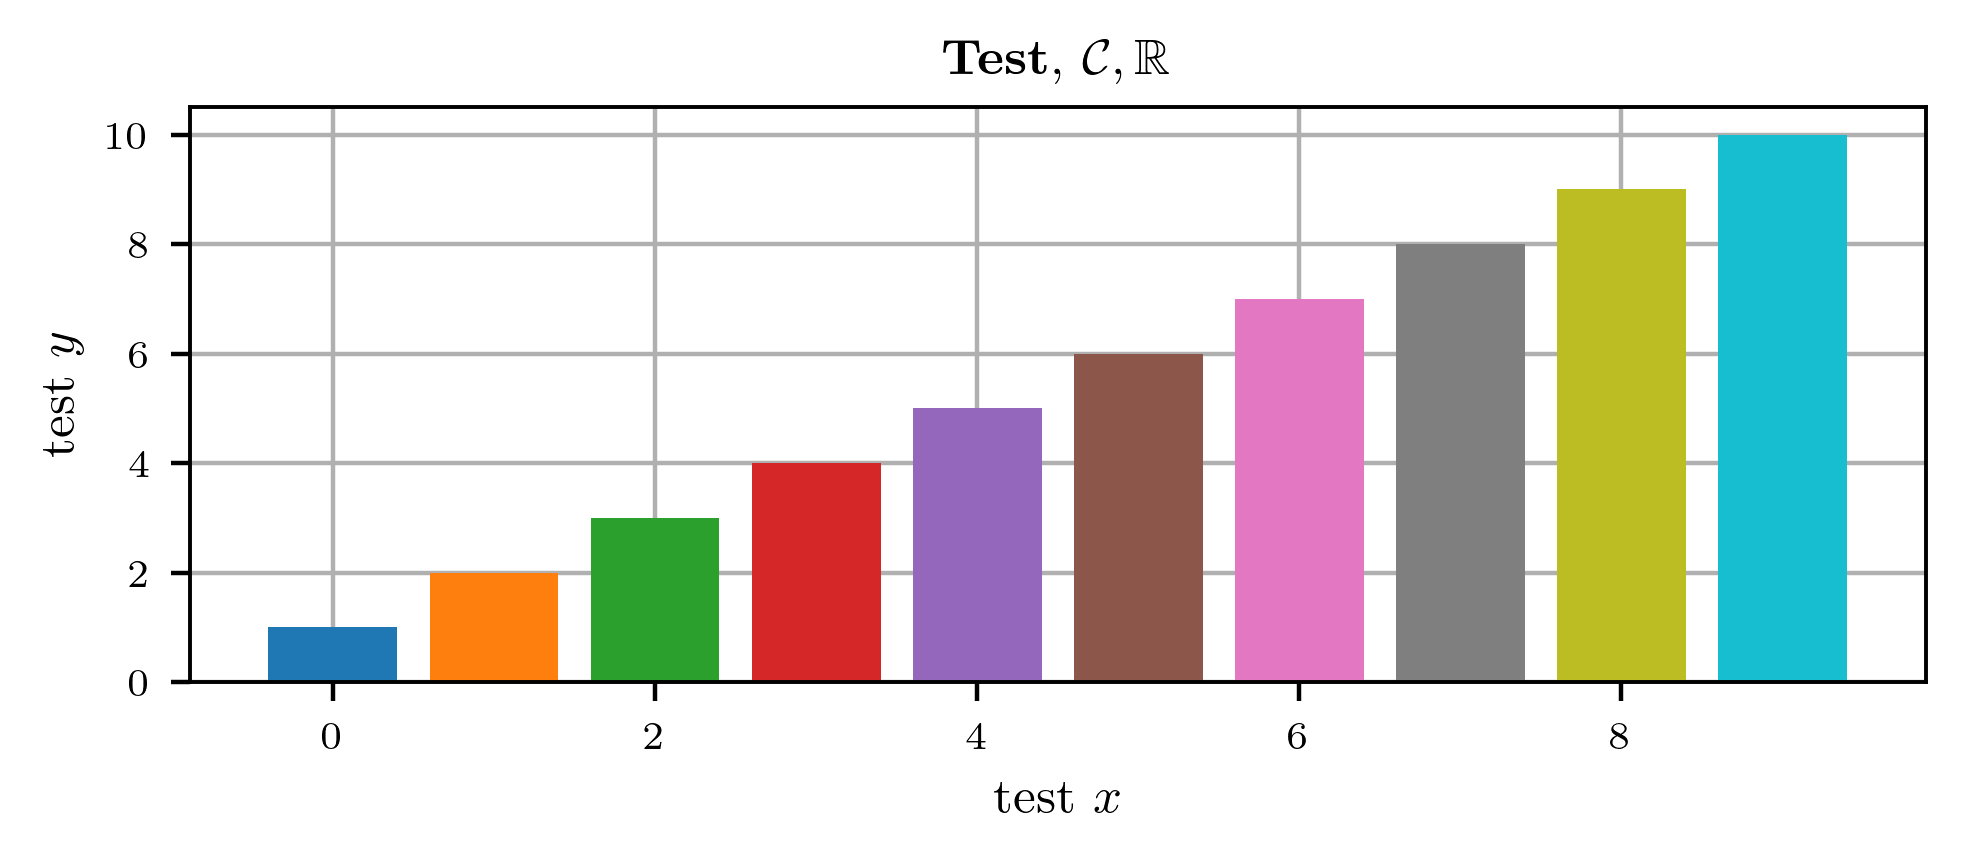

In [2]:
import matplotlib
# matplotlib.use('pgf')

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

markerlist = ['o', 4, 5, 6, 7, 'p', 'd', 'P']


text_width = 5.60107  # in  --> Confirmed with template explanation

fs_m1 = 7  # for figure ticks
fs = 9  # for regular figure text
fs_p1 = 10  # figure titles

axes_lw = 0.7

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('axes', linewidth=axes_lw)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})

matplotlib.rc('text', usetex=True)

plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsfonts}'})

# Test setup

plt.figure(dpi=400, figsize=(text_width, text_width/3))
plt.grid(0.3, zorder=0)
for i in range(10):
    plt.bar(i, i + 1, color=f'C{i}', zorder=2)
    # ^ This zorder nonsense makes the grid  lines go behid the bars. I don't know why this is needed for barplots, but shouldn't usually be needed.
plt.title(r'\textbf{Test}, $\mathcal{C}, \mathbb{R}$')
plt.xlabel('test $x$')
plt.ylabel('test $y$')
plt.show()

# Define errorfill


def errorfill(x, y, yerr, color=None, alpha_fill=0.3, line_alpha=1, ax=None,
              lw=1, linestyle='-', fill_linewidths=0.2,
              marker=None, markersize=1, label=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    plt_return = ax.plot(x, y, color=color, lw=lw, linestyle=linestyle, alpha=line_alpha, label=label, marker=marker, markersize=markersize)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill, linewidths=fill_linewidths)
    return plt_return


## package imports

In [4]:

import jax
from jax import jit, vmap
from functools import partial
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scalable_gps
from scalable_gps import data
from scalable_gps.kernels import RBFKernel
from scalable_gps.models.exact_gp_model import ExactGPModel
from scalable_gps.models.sgd_gp_model import SGDGPModel
from scalable_gps.models.inducing_sgd_gp_model import ISGDGPModel

import ml_collections



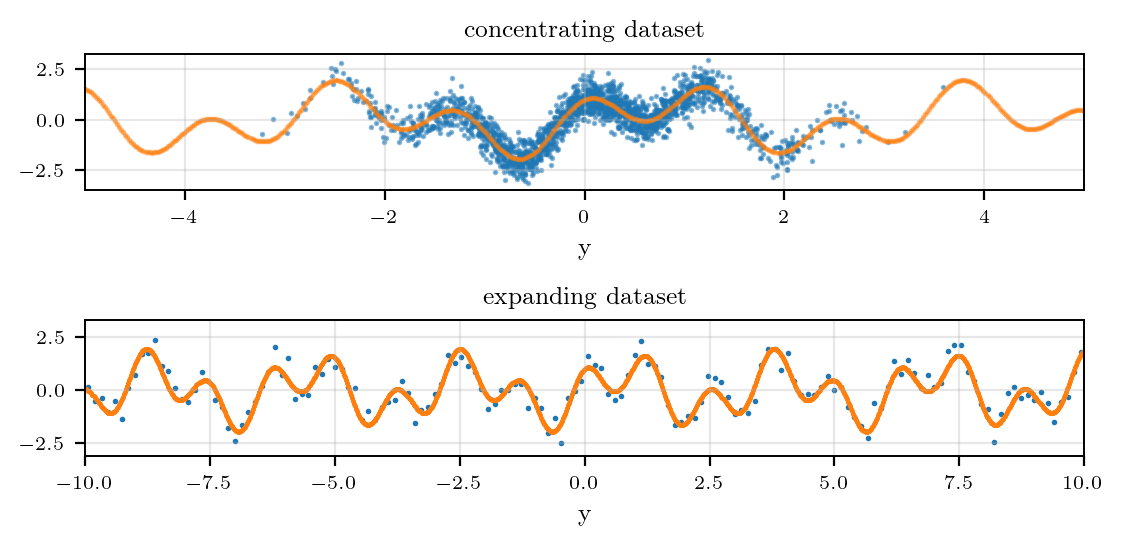

In [5]:


## Generate Data

noise_scale = 0.5
n_data = 2000
n_test = 1000
seed = 3

concentrate_data_train, concentrate_data_test = data.get_concentrating_toy_sin_dataset(
    seed=seed,
    n=n_data,
    noise_scale=noise_scale,
    n_test=n_test,
    x_std = 1.0,
    normalise=False
)



data_train, data_test = data.get_expanding_toy_sin_dataset(
    seed=seed,
    n=n_data,
    noise_scale=noise_scale,
    n_test=n_test,
    n_periods = 15,
    normalise=False
)

fig, ax = plt.subplots(2,1, figsize=(text_width,text_width/2), dpi=200)

ax[0].scatter(data_train.x, data_train.y,  1, alpha=0.5, c=c[0])
ax[0].scatter(concentrate_data_test.x, concentrate_data_test.y,  1, alpha=0.5, c=c[1])
ax[0].set_xlabel('x')
ax[0].set_xlabel('y')
ax[0].grid(alpha=0.3)
ax[0].set_xlim([-5,5])
ax[0].set_title('concentrating dataset')

ax[1].scatter(data_train.x, data_train.y,  1, alpha=1, c=c[0])
ax[1].scatter(data_test.x, data_test.y,  0.7, alpha=1, c=c[1])
ax[1].set_xlabel('x')
ax[1].set_xlabel('y')
ax[1].grid(alpha=0.3)
ax[1].set_xlim([-10,10])
ax[1].set_title('expanding dataset')

plt.tight_layout()


In [7]:


## hyperparams

kernel_config = {
    'signal_scale': jnp.array([2.]),
    'length_scale': jnp.array([0.5]),
}

kernel_config = {
    'signal_scale': jnp.array([2.]),
    'length_scale': jnp.array([0.5]),
}

concentrate_kernel = RBFKernel(kernel_config=kernel_config)
kernel = RBFKernel(kernel_config=kernel_config)



In [8]:

## ExactGP fits




concentrate_exact_gp = ExactGPModel(noise_scale=noise_scale, kernel=concentrate_kernel)
concentrate_exact_gp.compute_representer_weights(concentrate_data_train)
concentrate_exact_pred_mean = concentrate_exact_gp.predictive_mean(concentrate_data_train, concentrate_data_test)
concentrate_exact_pred_var = concentrate_exact_gp.predictive_variance(concentrate_data_train, concentrate_data_test) + noise_scale ** 2
concentrate_exact_pred_std = jnp.sqrt(concentrate_exact_pred_var)
print('concentrate_exact_pred_mean', concentrate_exact_pred_mean.shape, 'concentrate_exact_pred_var', concentrate_exact_pred_var.shape)


exact_gp = ExactGPModel(noise_scale=noise_scale, kernel=kernel)
exact_gp.compute_representer_weights(data_train)
exact_pred_mean = exact_gp.predictive_mean(data_train, data_test)
exact_pred_var = exact_gp.predictive_variance(data_train, data_test) + noise_scale ** 2
exact_pred_std = jnp.sqrt(exact_pred_var)
print('exact_pred_mean', exact_pred_mean.shape, 'exact_pred_var', exact_pred_var.shape)



concentrate_exact_pred_mean (1000,) concentrate_exact_pred_var (1000,)
exact_pred_mean (1000,) exact_pred_var (1000,)


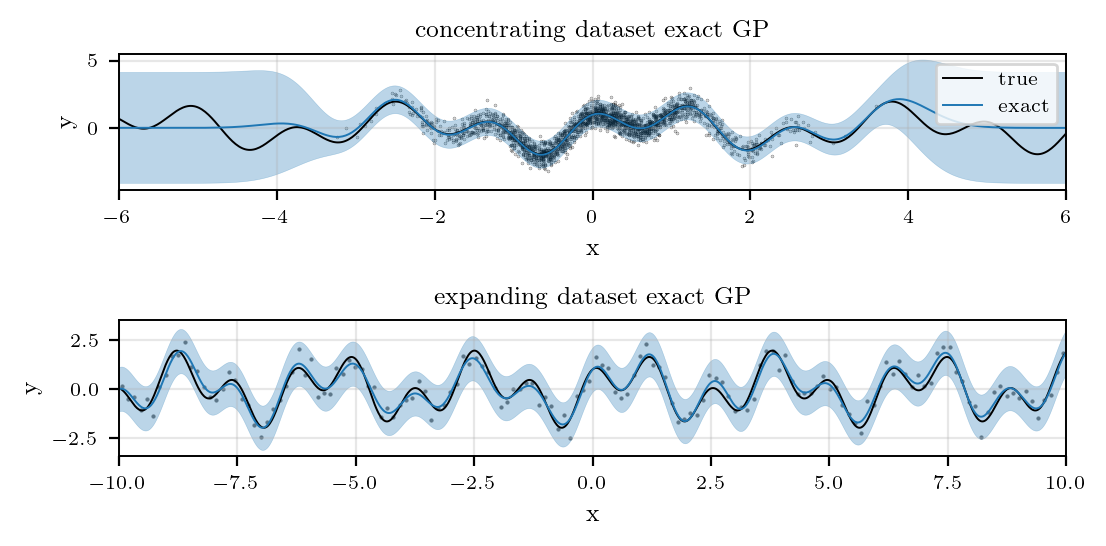

In [9]:


### view exact GP fits

fig, ax = plt.subplots(2,1, figsize=(text_width,text_width/2), dpi=200)

ax[0].scatter(concentrate_data_train.x, concentrate_data_train.y,  0.05, alpha=0.5, c='k')
ax[0].plot(concentrate_data_test.x, concentrate_data_test.y, alpha=1., c='k', linewidth=0.7, label='true')
errorfill(concentrate_data_test.x.squeeze(), concentrate_exact_pred_mean, 2*concentrate_exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.7, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='exact')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].grid(alpha=0.3)
ax[0].set_xlim([-6,6])
ax[0].legend()
ax[0].set_title('concentrating dataset exact GP')

ax[1].scatter(data_train.x, data_train.y,  0.3, alpha=0.5, c='k')
ax[1].plot(data_test.x, data_test.y, alpha=1., c='k', linewidth=0.7, label='true')
errorfill(data_test.x.squeeze(), exact_pred_mean, 2*exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[1],
              lw=0.7, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='exact')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].grid(alpha=0.3)
ax[1].set_xlim([-10,10])
ax[1].set_title('expanding dataset exact GP')

plt.tight_layout()

# Sampling fits

In [10]:


# from scalable_gps.utils import ExactPredictionsTuple

# concentrate_exact_metrics = ExactPredictionsTuple(
#                 alpha=concentrate_exact_gp.alpha, y_pred_loc=concentrate_exact_pred_mean)

# exact_metrics = ExactPredictionsTuple(
#                 alpha=exact_gp.alpha, y_pred_loc=exact_pred_mean)
            



### SGDGP

In [10]:





def info_to_dict(info, average_samples=True):
    keys = info[0].keys()

    training_results = {}

    for key in keys:
        result_vec = []
        for entry in info:
            if average_samples:
                result_vec.append(entry[key].mean(keepdims=True))
            else:
                result_vec.append(entry[key])
        training_results[key[1:]] = jnp.array(result_vec)
    return training_results

def plot_training_results(info):
    training_results = info_to_dict(info)
    num_entries = len(training_results.keys())
    fig, ax = plt.subplots(1,num_entries, dpi=200, figsize=(text_width,text_width/3))
    for i, key in enumerate(training_results.keys()):
        ax[i].plot(training_results[key])
        ax[i].set_yscale('log')
        ax[i].grid(alpha=0.3)
        ax[i].set_title(key)
    plt.tight_layout()
    plt.show()

### config

### config

In [123]:
config = ml_collections.ConfigDict()
config.train_config = ml_collections.ConfigDict()

config.train_config.iterations = 5000
config.train_config.batch_size = 500
config.train_config.eval_every = 100

# RFF Configs
config.train_config.n_features_optim = 100
config.train_config.recompute_features = True

# Optimisation Configs
config.train_config.iterative_idx = True
config.train_config.learning_rate = 0.1
config.train_config.momentum = 0.9
config.train_config.nesterov = True
config.train_config.time_budget_in_seconds = -1
config.train_config.eval_every_in_seconds = None

polyak_k = 50
polyak_step = polyak_k / config.train_config.iterations
print('polyak_step', polyak_step)
config.train_config.polyak = polyak_step

config.train_config.absolute_clipping = 0.1  # -1 to avoid clipping

config.train_config.lr_schedule_name = None # "linear_schedule"
config.train_config.lr_schedule_config = ml_collections.ConfigDict()


# sampling 

config.sampling_config = ml_collections.ConfigDict()

config.sampling_config = config.train_config.copy_and_resolve_references()
config.sampling_config.n_samples = 100
# Full-batch training configs that get passed
config.sampling_config.iterative_idx = True
config.sampling_config.learning_rate = 2e-5
config.sampling_config.momentum = 0.9
config.sampling_config.iterations = 30000
config.sampling_config.batch_size = 500
config.sampling_config.absolute_clipping = 0.1  # -1 to avoid clipping


config.sampling_config.eval_every = 100 # eval every how many number of steps 

polyak_k = 50
polyak_step = polyak_k / config.sampling_config.iterations
print('polyak_step', polyak_step)
config.sampling_config.polyak = polyak_step


# RFF Configs
config.sampling_config.n_features_prior_sample = 3000
config.sampling_config.n_features_optim = 100
config.sampling_config.recompute_features = True
config.sampling_config.loss_objective = 2
# config.sampling_config.use_cholesky_prior_sample = False


config.train_config.time_budget_in_seconds = -1
config.train_config.eval_every_in_seconds = None

metrics_list = ["loss", "err", "reg",  "test_rmse"] # 


polyak_step 0.01
polyak_step 0.0016666666666666668


In [69]:

optim_key = jax.random.PRNGKey(0)


#### concetrate

In [78]:
def get_inducing_dataset(dataset, inducing_points):
    assert dataset.x.shape[-1] == inducing_points.shape[-1]
    dataset = dataset._asdict()
    dataset['z'] =  inducing_points # concentrate_data_train['x'] #
    dataset = Dataset(**dataset)
    return dataset


100%|██████████| 10000/10000 [01:21<00:00, 123.36it/s]


zero_mean_samples : (50, 1000)
alpha_samples : (50, 500)


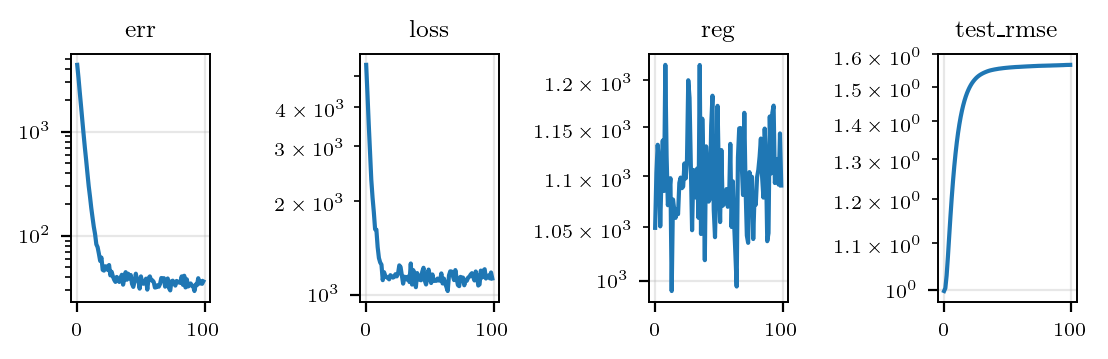

In [124]:
from scalable_gps.data import Dataset

config.train_config.learning_rate = 0.5
config.train_config.iterations = 6000

config.sampling_config.learning_rate = 1e-4
config.sampling_config.iterations = 10000

config.sampling_config.n_samples = 50

concentrate_isgd_gp = ISGDGPModel(noise_scale=noise_scale, kernel=concentrate_kernel)

N_inducing = 500
inducing_points = jnp.linspace(concentrate_data_train.x.min(), concentrate_data_train.x.max(), N_inducing)[..., None]
concentrate_data_train = get_inducing_dataset(concentrate_data_train, inducing_points)

# MAP
# concentrate_alpha_polyak, info = concentrate_isgd_gp.compute_representer_weights(
#     key=optim_key,
#     train_ds=concentrate_data_train, 
#     test_ds=concentrate_data_test,
#     config=config.train_config,
#     metrics_list=metrics_list,
#     exact_metrics=None,#concentrate_exact_metrics  # exact_metrics
# )

# concentrate_isgd_pred_mean = concentrate_isgd_gp.predictive_mean(concentrate_data_train, concentrate_data_test)
# plot_training_results(info)

# sampling

concentrate_zero_mean_samples, concentrate_alpha_samples, concentrate_w_samples, info = concentrate_isgd_gp.compute_posterior_samples(
                                        optim_key, 
                                        n_samples=config.sampling_config.n_samples,
                                        train_ds=concentrate_data_train,
                                        test_ds=concentrate_data_test,
                                        config=config.sampling_config,
                                        use_rff=True,
                                        n_features=config.sampling_config.n_features_prior_sample,
                                        metrics_list = metrics_list,
                                        compare_exact=False,  # allows diff metrics with exact GP
                                    )
concentrate_isgd_pred_var_samples = concentrate_isgd_gp.predictive_variance_samples(concentrate_zero_mean_samples) + noise_scale ** 2
concentrate_isgd_pred_std_samples = jnp.sqrt(concentrate_isgd_pred_var_samples)

print(f'zero_mean_samples : {concentrate_zero_mean_samples.shape}')
print(f'alpha_samples : {concentrate_alpha_samples.shape}')

plot_training_results(info)



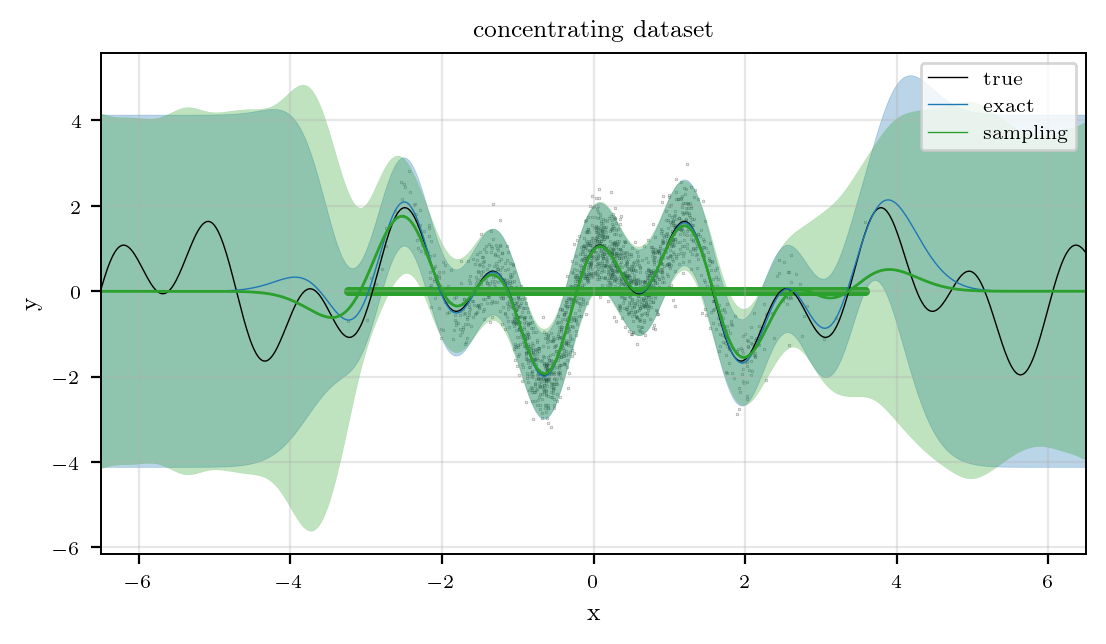

In [126]:
fig, ax = plt.subplots(1,1, figsize=(text_width,text_width/1.7), dpi=200)
ax = [ax]

ax[0].scatter(concentrate_data_train.x, concentrate_data_train.y,  0.03, alpha=0.5, c='k')
ax[0].plot(concentrate_data_test.x, concentrate_data_test.y, alpha=1., c='k', linewidth=0.5, label='true')

errorfill(concentrate_data_test.x.squeeze(), concentrate_exact_pred_mean, 2*concentrate_exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.5, linestyle='-', fill_linewidths=0.3, marker=None, markersize=1, label='exact')


ax[0].scatter(inducing_points, jnp.zeros(len(inducing_points)), 5, c=c[2])


errorfill(concentrate_data_test.x.squeeze(), concentrate_isgd_pred_mean, 2*concentrate_isgd_pred_std_samples,
          color=c[2], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.5, linestyle='-', fill_linewidths=0.1, marker=None, markersize=1, label='sampling')


ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].grid(alpha=0.3)
ax[0].set_xlim([-6.5,6.5])
ax[0].legend()
ax[0].set_title('concentrating dataset')




plt.tight_layout()

100%|██████████| 10000/10000 [02:00<00:00, 83.20it/s]


zero_mean_samples : (50, 1000)
alpha_samples : (50, 1000)


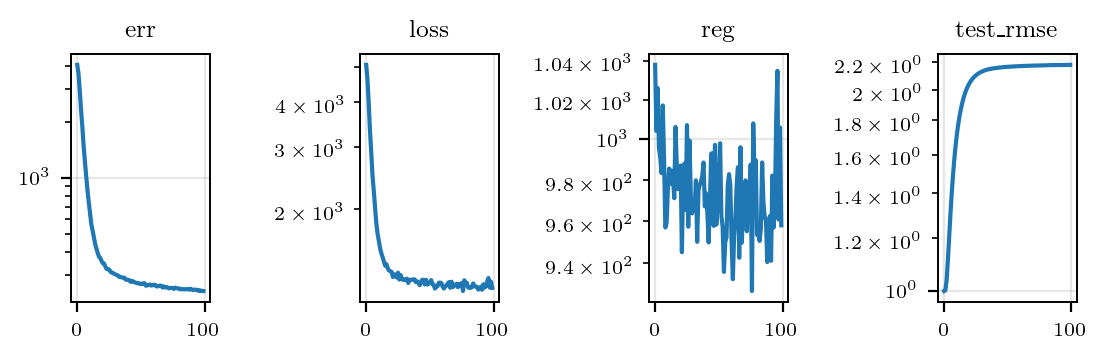

In [139]:

config.train_config.learning_rate = 0.5
config.train_config.iterations = 6000


config.sampling_config.learning_rate = 5e-3
config.sampling_config.iterations = 10000
config.sampling_config.n_samples = 50

isgd_gp = ISGDGPModel(noise_scale=noise_scale, kernel=kernel)

N_inducing = 1000
inducing_points = jnp.linspace(data_train.x.min(), data_train.x.max(), N_inducing)[..., None]
data_train = get_inducing_dataset(data_train, inducing_points)


# MAP
# alpha_polyak, info = isgd_gp.compute_representer_weights(
#     key=optim_key,
#     train_ds=data_train, 
#     test_ds=data_test,
#     config=config.train_config,
#     metrics_list=metrics_list,
#     exact_metrics=None,  # exact_metrics
# )

# isgd_pred_mean = isgd_gp.predictive_mean(data_train, data_test)
# plot_training_results(info)


zero_mean_samples, alpha_samples, concentrate_w_samples, info = isgd_gp.compute_posterior_samples(
                                        optim_key, 
                                        n_samples=config.sampling_config.n_samples,
                                        train_ds=data_train,
                                        test_ds=data_test,
                                        config=config.sampling_config,
                                        use_rff=True,
                                        n_features=config.sampling_config.n_features_prior_sample,
                                        metrics_list = metrics_list,
                                        compare_exact=False,  # allows diff metrics with exact GP
                                    )
isgd_pred_var_samples = isgd_gp.predictive_variance_samples(zero_mean_samples) + noise_scale ** 2
isgd_pred_std_samples = jnp.sqrt(isgd_pred_var_samples)

print(f'zero_mean_samples : {zero_mean_samples.shape}')
print(f'alpha_samples : {alpha_samples.shape}')

plot_training_results(info)



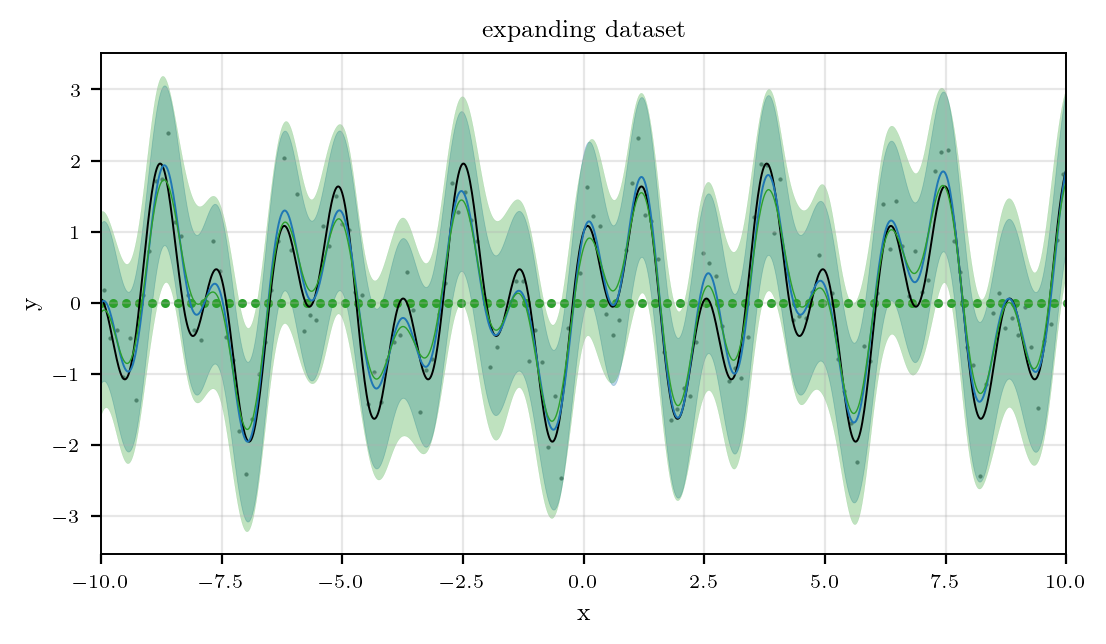

In [141]:
fig, ax = plt.subplots(1,1, figsize=(text_width,text_width/1.7), dpi=200)

ax = [ax]






ax[0].scatter(data_train.x, data_train.y,  0.3, alpha=0.5, c='k')
ax[0].plot(data_test.x, data_test.y, alpha=1., c='k', linewidth=0.7, label='true')
errorfill(data_test.x.squeeze(), exact_pred_mean, 2*exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.7, linestyle='-', fill_linewidths=0.3, marker=None, markersize=1, label='exact')



ax[0].scatter(inducing_points, jnp.zeros(len(inducing_points)), 5, c=c[2])

errorfill(data_test.x.squeeze(), isgd_pred_mean, 2*isgd_pred_std_samples,
          color=c[2], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.5, linestyle='-', fill_linewidths=0.1, marker=None, markersize=1, label='sampling')


ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].grid(alpha=0.3)
ax[0].set_xlim([-10,10])
ax[0].set_title('expanding dataset')

plt.tight_layout()